#  Logistic Regression and Classification Error Metrics

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial Angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website: above or at https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones 

In [1]:
from __future__ import print_function
import os
#Data Path has to be set as per the file location in your system
#data_path = ['..', 'data']
data_path = ['data']

## Question 1

Import the data and do the following:

* Examine the data types--there are many columns, so it might be wise to use value counts
* Determine if the floating point values need to be scaled
* Determine the breakdown of each activity
* Encode the activity label as an integer

In [2]:
import pandas as pd
import numpy as np
#The filepath is dependent on the data_path set in the previous cell 
filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data columns are all floats except for the activity label.

In [3]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [4]:
data.dtypes.tail()

angle(tBodyGyroJerkMean,gravityMean)    float64
angle(X,gravityMean)                    float64
angle(Y,gravityMean)                    float64
angle(Z,gravityMean)                    float64
Activity                                 object
dtype: object

The data are all scaled from -1 (minimum) to 1.0 (maximum).

In [5]:
data.iloc[:, :-1].min().value_counts()

-1.0    561
dtype: int64

In [6]:
data.iloc[:, :-1].max().value_counts()

1.0    561
dtype: int64

Examine the breakdown of activities--they are relatively balanced.

In [7]:
data.Activity.value_counts()

LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: Activity, dtype: int64

Scikit learn classifiers won't accept a sparse matrix for the prediction column. Thus, either `LabelEncoder` needs to be used to convert the activity labels to integers, or if `DictVectorizer` is used, the resulting matrix must be converted to a non-sparse array.  
Use `LabelEncoder` to fit_transform the "Activity" column, and look at 5 random values.

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

1417    3
7620    4
3275    2
5011    3
2141    3
Name: Activity, dtype: int64

## Question 2

* Calculate the correlations between the dependent variables.
* Create a histogram of the correlation values
* Identify those that are most correlated (either positively or negatively).

In [9]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

A histogram of the absolute value correlations.

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

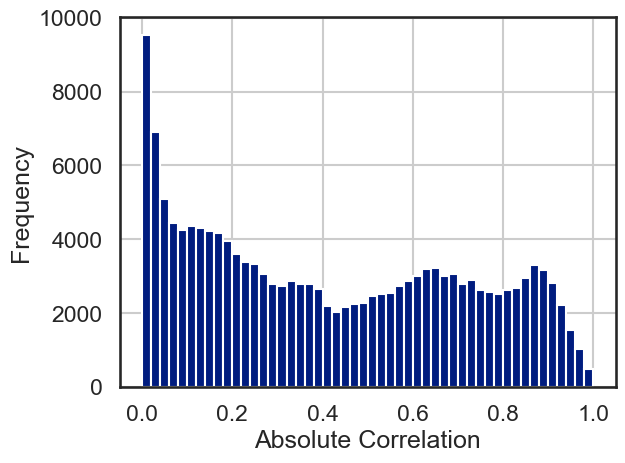

In [11]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = corr_values.abs_correlation.hist(bins=50)

ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [12]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
156894,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
93902,tBodyAccMag-sma(),tGravityAccMag-sma(),1.000000,1.000000
101139,tBodyAccJerkMag-mean(),tBodyAccJerkMag-sma(),1.000000,1.000000
96706,tGravityAccMag-mean(),tGravityAccMag-sma(),1.000000,1.000000
94257,tBodyAccMag-energy(),tGravityAccMag-energy(),1.000000,1.000000
...,...,...,...,...
22657,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39225,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38739,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23176,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


## Question 3

* Split the data into train and test data sets. This can be done using any method, but consider using Scikit-learn's `StratifiedShuffleSplit` to maintain the same ratio of predictor classes.
* Regardless of methods used to split the data, compare the ratio of classes in both the train and test splits.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']


In [14]:
y_train.value_counts(normalize=True)

0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: Activity, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: Activity, dtype: float64

## Question 4

* Fit a logistic regression model without any regularization using all of the features. Be sure to read the documentation about fitting a multi-class model so you understand the coefficient output. Store the model.
* Using cross validation to determine the hyperparameters, fit models using L1, and L2 regularization. Store each of these models as well. Note the limitations on multi-class models, solvers, and regularizations. The regularized models, in particular the L1 model, will probably take a while to fit.

In [16]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(max_iter=500, penalty='none').fit(X_train, y_train)
lr.coef_

array([[-8.21159462e+01,  1.43337928e+01,  1.82844671e+01, ...,
         7.75095360e+02, -3.11953419e+02, -7.48951354e+01],
       [-2.84930475e+02, -1.19586435e+02,  3.04336113e+01, ...,
        -8.10393931e+01, -1.44245940e+02, -9.09842175e+01],
       [ 1.31394695e+02,  9.17722907e+01,  1.04943416e+02, ...,
        -3.36482719e+02,  2.57869823e+02,  2.39541481e+01],
       [-2.20350099e+00, -1.91259218e+01, -1.61176380e+00, ...,
        -1.38852676e+02,  1.53628096e+01,  6.64967079e+01],
       [ 1.63279933e+02,  3.93963928e+01, -2.43897771e-02, ...,
        -2.81079546e+02, -2.10013081e+01, -6.73461058e+00],
       [ 7.45752936e+01, -6.79011964e+00, -1.52025340e+02, ...,
         6.23589745e+01,  2.03968035e+02,  8.21631074e+01]])

In [17]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [72]:
#Try with different solvers like ‘newton-cg’, ‘lbfgs’, ‘sag’, ‘saga’ and give your observations
saga = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='saga').fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

In [ ]:
# A penalidade l1 é aplicável para os algorítmos de resolução 'liblinear' e 'saga'

In [19]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train, y_train)

In [73]:
lbfgs = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='lbfgs', max_iter=100).fit(X_train, y_train)
liblinear_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear', max_iter=100).fit(X_train, y_train)
newton1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cg', max_iter=100).fit(X_train, y_train)
newton2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='newton-cholesky', max_iter=100).fit(X_train, y_train)
sag = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='sag', max_iter=100).fit(X_train, y_train)
saga_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='saga', max_iter=100).fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got newton-cholesky.

In [ ]:
# A penalidade l2 é aplicável para os algorítmos de resolução 'lbfgs', 'liblinear', 'newton', 'sag' e 'saga'

## Question 5

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately. 

In [20]:
# Combine all the coefficients into a dataframe
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

#for lab,mod in zip(coeff_labels, coeff_models):
#    coeffs = mod.coef_
#    levels=[[lab], [0,1,2,3,4,5]]
#    labels=[[0,0,0,0,0,0], [0,1,2,3,4,5]]
#    coeff_label = pd.MultiIndex(levels,labels)
#    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)



lr                                                              \
              0           1           2           3           4           5   
443  -50.552439 -131.598298   80.427652  -39.670154  213.791269  -72.398030   
510 -130.755503 -336.928055  -98.015904  129.201263  273.812351  162.685848   
229 -107.301600  -20.482160 -151.234815  154.559964 -113.216365  237.674976   
140  -71.248209   69.612630 -203.711794  154.001814  -52.039323  103.384882   
327    4.942060   16.419025   45.931198   -1.462173   -1.240925  -64.589184   
514   77.470480  105.001424  276.118079 -313.085981 -155.994162   10.490160   
26   -70.077759  -53.129137   96.811712   84.588272 -134.719473   76.526385   
10    -9.207515 -348.515330  166.970490   48.498447  -61.035731  203.289639   
279   31.496377  290.868749 -225.733260  -45.178076 -103.033915   51.580125   
103 -195.049269 -284.238655 -165.945433  348.801333    8.609016  287.823008   

      l1                                                          l2  \
       0         1         2         3         4         5         0   
443  0.0  0.000000  0.000000 -0.078849  0.552343 -0.925470 -0.007281   
510  0.0  0.000000  0.000000  0.005853  0.798751  0.968233 -0.040488   
229  0.0  0.000000  0.000000  0.253918 -0.572625  0.182361 -0.073473   
140  0.0  0.000000  0.000000  0.549402 -0.400281  1.313366 -0.036017   
327  0.0  0.157121  0.000000  0.105905  0.000000 -0.091498  0.000200   
514  0.0  0.690457  0.000000 -0.570392  0.000000  0.335554  0.198684   
26   0.0  0.000000  0.000000  0.000000 -1.202806  2.040487 -0.101545   
10   0.0 -4.157340  0.000000  0.000000 -2.340568  4.969770  0.054601   
279  0.0  1.704131  0.000000  0.136816  0.000000  0.560457  0.014979   
103  0.0  0.000000 -0.023234  1.672517 -0.247304  1.503207 -0.188572   

                                                       
            1         2         3         4         5  
443 -0.266463  0.190357 -0.114679  0.431275 -0.233209  
510 -0.308040 -0.016673 -0.179211  0.428535  0.115877  
229 -0.019254 -0.143653  0.210397 -0.396148  0.422132  
140  0.153614 -0.388278  0.305717 -0.309829  0.274793  
327 -0.024818  0.003074  0.092177  0.043298 -0.113930  
514  0.358729 -0.035084 -0.618740 -0.181392  0.277803  
26   0.145623 -0.029796 -0.000596 -0.288499  0.274813  
10  -0.768614  0.485607  0.017154 -0.178443  0.389695  
279  0.529076 -0.462970 -0.028527 -0.178418  0.125859  
103 -0.106741 -0.239265  0.607624 -0.421525  0.348479

Prepare six separate plots for each of the multi-class coefficients.

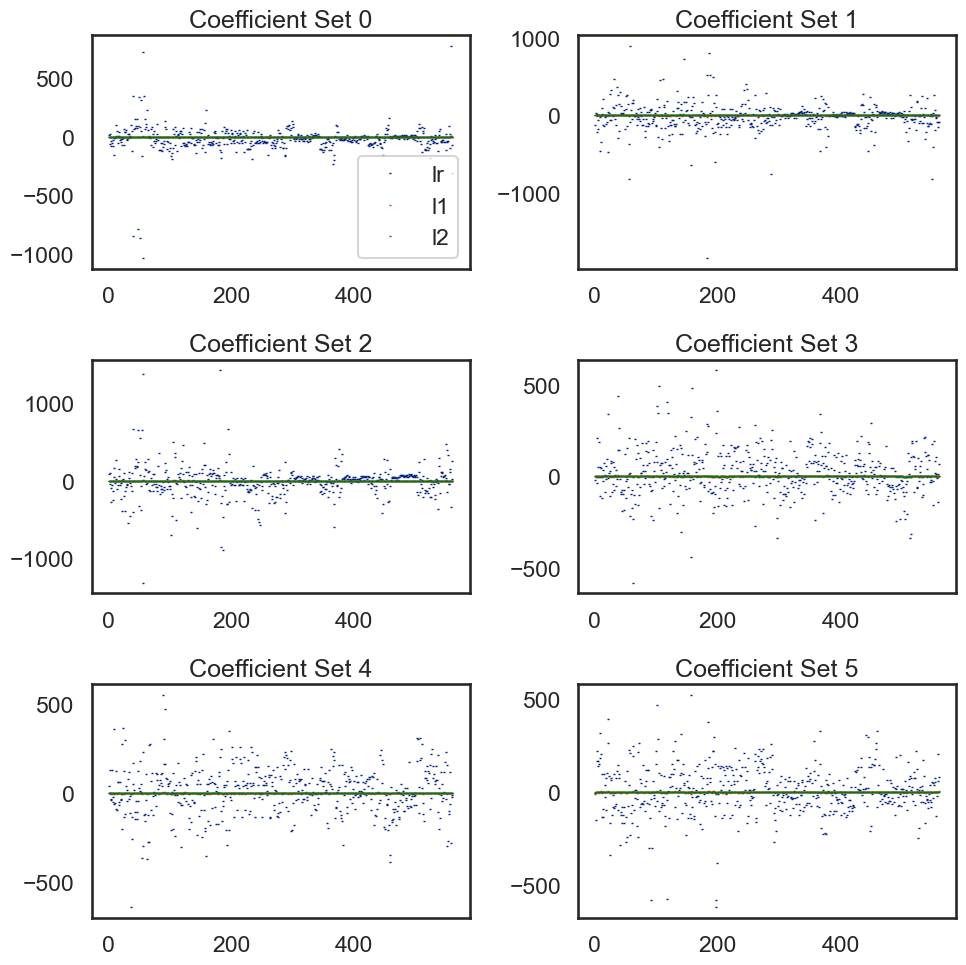

In [74]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]

    data_aux = coefficients.xs(loc, level=1, axis=1)
    data_aux.plot(marker='_', ls='', ms=1.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()




In [77]:
# Coeficientes no modelo sem penalidade apresentam altíssima variância.

## Question 6

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model. 

In [36]:
# Predict the class and the probability for each

y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()



,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [37]:
y_prob.head()

,lr,l1,l2
0,1.0,0.998899,0.999999
1,1.0,0.999667,0.999655
2,1.0,0.995709,0.998873
3,1.0,0.999190,0.997828
4,1.0,0.999920,0.999309


## Question 7

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [54]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)


In [55]:
#Run the metrics
metrics

,lr,l1,l2
precision,0.981525,0.983835,0.983485
recall,0.981553,0.983819,0.983495
fscore,0.981536,0.983815,0.983488
accuracy,0.981553,0.983819,0.983495
auc,0.988834,0.990144,0.989983


In [78]:
# Os valores das métricas foram bem próximos para todos os métodos

## Question 8

Display or plot the confusion matrix for each model.

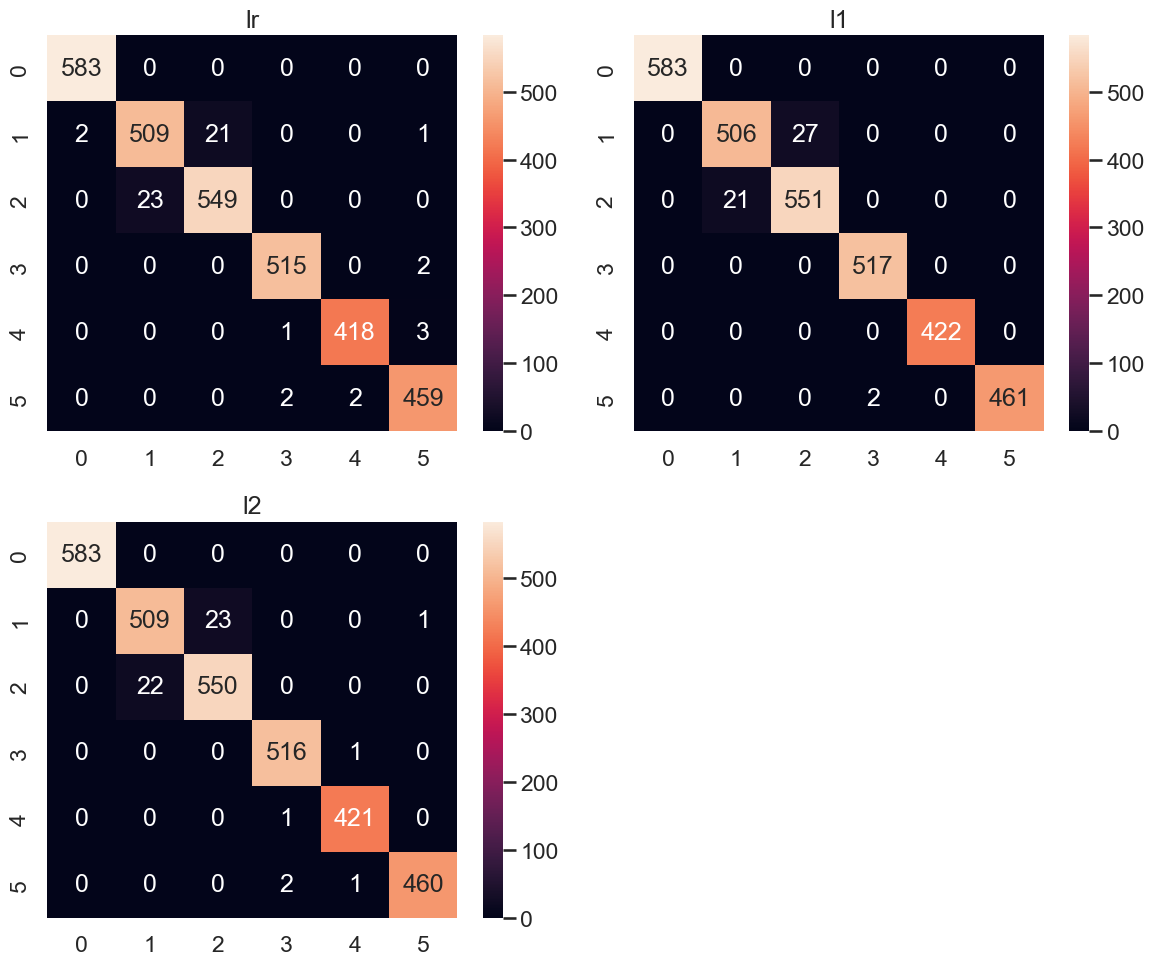

In [56]:

fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()


In [79]:
# Matriz de confusão apresentando real x predição para os 3 métodos

## Question 9
 Identify highly correlated columns and drop those columns before building models

In [41]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold


X_data = data.iloc[:, :-1]


#threshold with .7
sel = VarianceThreshold(threshold=(.7 * (1 - .7)))
X_data = pd.DataFrame(sel.fit_transform(X_data))


feature_cols = X_data.columns[:]


# Dividindo os subjconjuntos de treino e teste, seguindo os mesmos
# Indices obtidos com Stratified Shuffle Split, agora com os dados
# Com menos features
 

X_train_new = X_data.loc[train_idx, :]

y_train_new = data.loc[train_idx, 'Activity']
 
X_test_new  = X_data.loc[test_idx, :]
y_test_new  = data.loc[test_idx, 'Activity']
 
print(X_train.shape)
print(X_train_new.shape)
 
print(X_test.shape)

(7209, 561)
(7209, 50)
(3090, 561)


In [80]:
# O VarianceThreshold está eliminando coeficientes cujo valor em módulo está acima de um determinado limiar.

 Repeat Model building with new training data after removing higly correlated columns

In [42]:
# Try standard, L1 and L2 Logistic regression
lr_new = LogisticRegression(max_iter=500, penalty='none').fit(X_train_new, y_train_new)
lr_l1_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train_new, y_train_new)
lr_l2_new = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', max_iter=10000).fit(X_train_new, y_train_new)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of

## Question 10

Compare the magnitudes of the coefficients for each of the models. If one-vs-rest fitting was used, each set of coefficients can be plotted separately.

In [46]:
# Combine all the coefficients into a dataframe for comparison
coefficients_new = list()
for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]],
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients_new.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients_new = pd.concat(coefficients_new, axis=1)

coefficients_new.sample(10)

lr                                                         \
            0          1          2          3          4          5   
25   2.339496  -1.071659  -0.429686  -7.980428   7.808088  -0.665811   
24   0.614641  -2.751617   1.436552   3.470859  -1.145276  -1.625159   
44  -2.939260  -3.233276  -0.184964   1.708411  -3.083288   7.732377   
10   1.766097   0.852350   1.342854  -1.132244  -1.735345  -1.093712   
49  12.631146 -19.391513  14.989228  -6.737139 -17.067380  15.575658   
12   0.475909  -2.323211  -7.698284  11.651701 -10.972771   8.866656   
26  -0.665772  -2.055776  -4.698862  17.773244   8.388240 -18.741074   
9   -0.659602  -0.846801  -0.079884   0.547929   0.659387   0.378972   
33  -0.476771  -4.262024  -4.097826   2.084172   2.492155   4.260294   
17  -0.342827  -1.080672  -3.031437   4.029832  -3.162577   3.587681   

          l1                                                               l2  \
           0          1          2          3          4          5         0   
25  0.000000  -0.401067   1.658473  -6.130149   7.870632   1.879877  1.199016   
24  0.000000  -0.440762   0.925955   9.860986  -2.059394   0.000000  1.429190   
44  0.000000  -0.860958   5.242880  -1.316049  -5.584835   4.609541 -1.440924   
10  0.000000  -0.506005   0.533503   0.101075  -0.418938   0.337126  1.890967   
49  0.000000 -25.646940  34.283737  -7.190359 -11.709343  20.477293  8.918040   
12  0.000000   2.762489  -5.653929  10.138038 -14.105222   8.318451 -0.633610   
26  0.000000   3.190695  -2.649248  23.050012  13.052377 -10.927566 -1.529016   
9   0.644247  -0.753985   0.724511  -0.089245   0.042063   0.261912  0.305201   
33  0.000000   1.239614  -0.044311  -2.336951   1.841237   2.607582 -1.227067   
17  0.000000   1.517856  -1.389546   1.550875  -3.908913   3.113341 -1.000250   

                                                           
            1          2          3          4          5  
25   0.394389   1.202767  -9.519430   7.525269  -0.802011  
24  -0.395776   0.820061   4.033748  -3.167591  -2.719632  
44  -3.504392  -0.436426   0.851075  -2.290296   6.820963  
10   0.428744   0.925889  -0.771058  -1.546863  -0.927680  
49 -20.785819  18.064161  -1.542802 -15.489663  10.836083  
12  -1.956571  -8.222158  12.725070 -10.669962   8.757231  
26  -1.324393  -4.309001  15.738859   7.481568 -16.058017  
9   -1.872163  -1.148602   1.053880   0.879280   0.782404  
33  -2.793601  -3.043526   0.089831   3.117930   3.856432  
17  -0.435481  -2.335521   4.181142  -3.638820   3.228931

Prepare six separate plots for each of the multi-class coefficients.

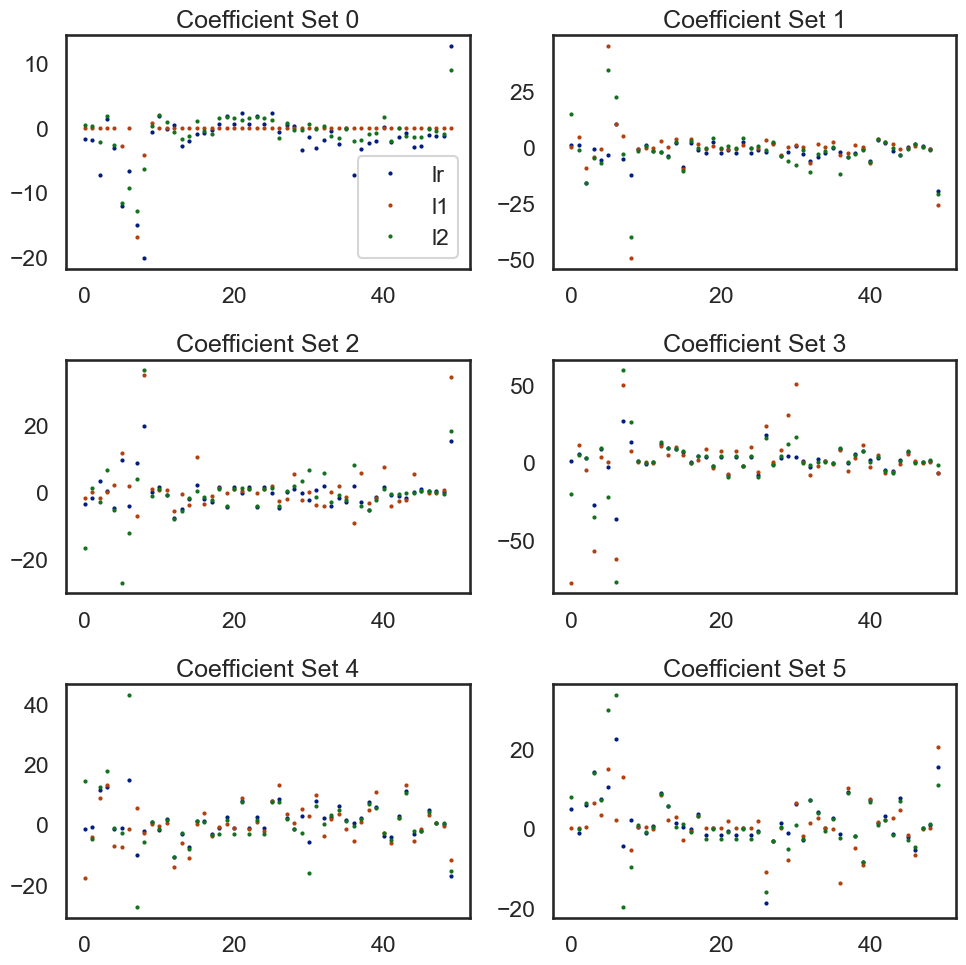

In [49]:
# try the plots
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)


for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]

    data_aux = coefficients_new.xs(loc, level=1, axis=1)
    data_aux.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)

    if ax is axList[0]:
        ax.legend(loc=4)

    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()


## UAU os coeficientes apresentam uma variância dez vezes menor!!11!!1

## Question 11

* Predict and store the class for each model.
* Also store the probability for the predicted class for each model.

In [44]:
# Predict the class and the probability for each
y_pred_new = list()
y_prob_new = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr_new, lr_l1_new, lr_l2_new]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred_new.append(pd.Series(mod.predict(X_test_new), name=lab))
    y_prob_new.append(pd.Series(mod.predict_proba(X_test_new).max(axis=1), name=lab))

y_pred_new = pd.concat(y_pred_new, axis=1)
y_prob_new = pd.concat(y_prob_new, axis=1)

## Question 12

For each model, calculate the following error metrics: 

* accuracy
* precision
* recall
* fscore
* confusion matrix

Decide how to combine the multi-class metrics into a single value for each model.

In [50]:
metrics_new = list()
cm_new = dict()

for lab in coeff_labels:
    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test_new, y_pred_new[lab], average='weighted')

    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test_new, y_pred_new[lab])

    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test_new, classes=[0, 1, 2, 3, 4, 5]),
                        label_binarize(y_pred_new[lab], classes=[0, 1, 2, 3, 4, 5]),
                        average='weighted')

    # Last, the confusion matrix
    cm_new[lab] = confusion_matrix(y_test_new, y_pred_new[lab])

    metrics_new.append(pd.Series({'precision': precision, 'recall': recall,
                              'fscore': fscore, 'accuracy': accuracy,
                              'auc': auc},
                             name=lab))

metrics_new = pd.concat(metrics_new, axis=1)

#Run the metrics
metrics_new

,lr,l1,l2
precision,0.935331,0.937980,0.936643
recall,0.935275,0.937864,0.936570
fscore,0.935234,0.937868,0.936555
accuracy,0.935275,0.937864,0.936570
auc,0.961176,0.962638,0.961954


## Question 13

Display or plot the confusion matrix for each model.

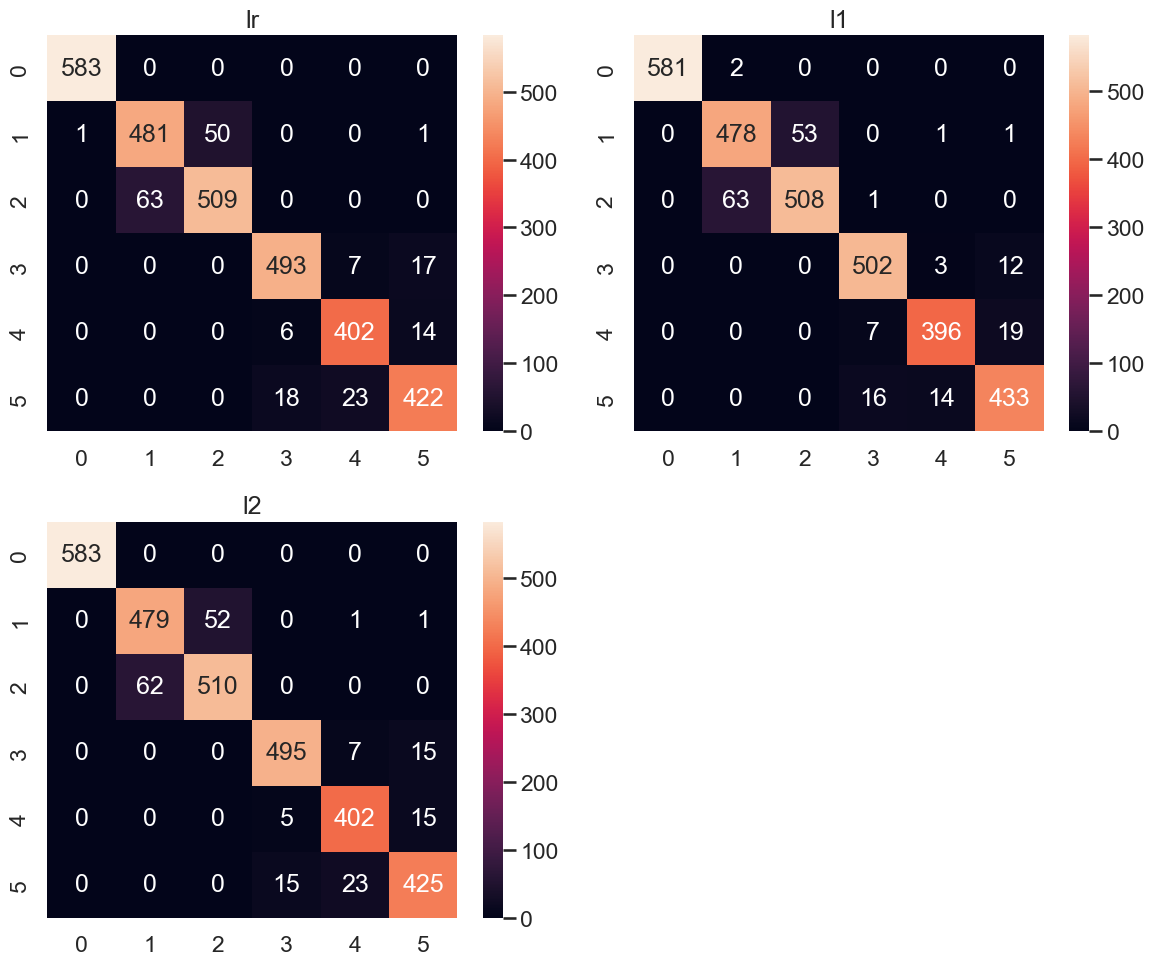

In [51]:
#plot the confusion matrix
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm_new[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);

plt.tight_layout()

In [53]:
# Perform a comparison of the outputs between Question 7 and 12 and give your observation
metrics_new-metrics

,lr,l1,l2
precision,-0.046194,-0.045855,-0.046843
recall,-0.046278,-0.045955,-0.046926
fscore,-0.046302,-0.045947,-0.046933
accuracy,-0.046278,-0.045955,-0.046926
auc,-0.027658,-0.027506,-0.028028


## O sistema tem perda nas previsões, visto acima. Uma troca pelo tempo de execução reduzido

In [37]:
# Perform a comparison of the outputs between Question 8 and 13 and give your observation

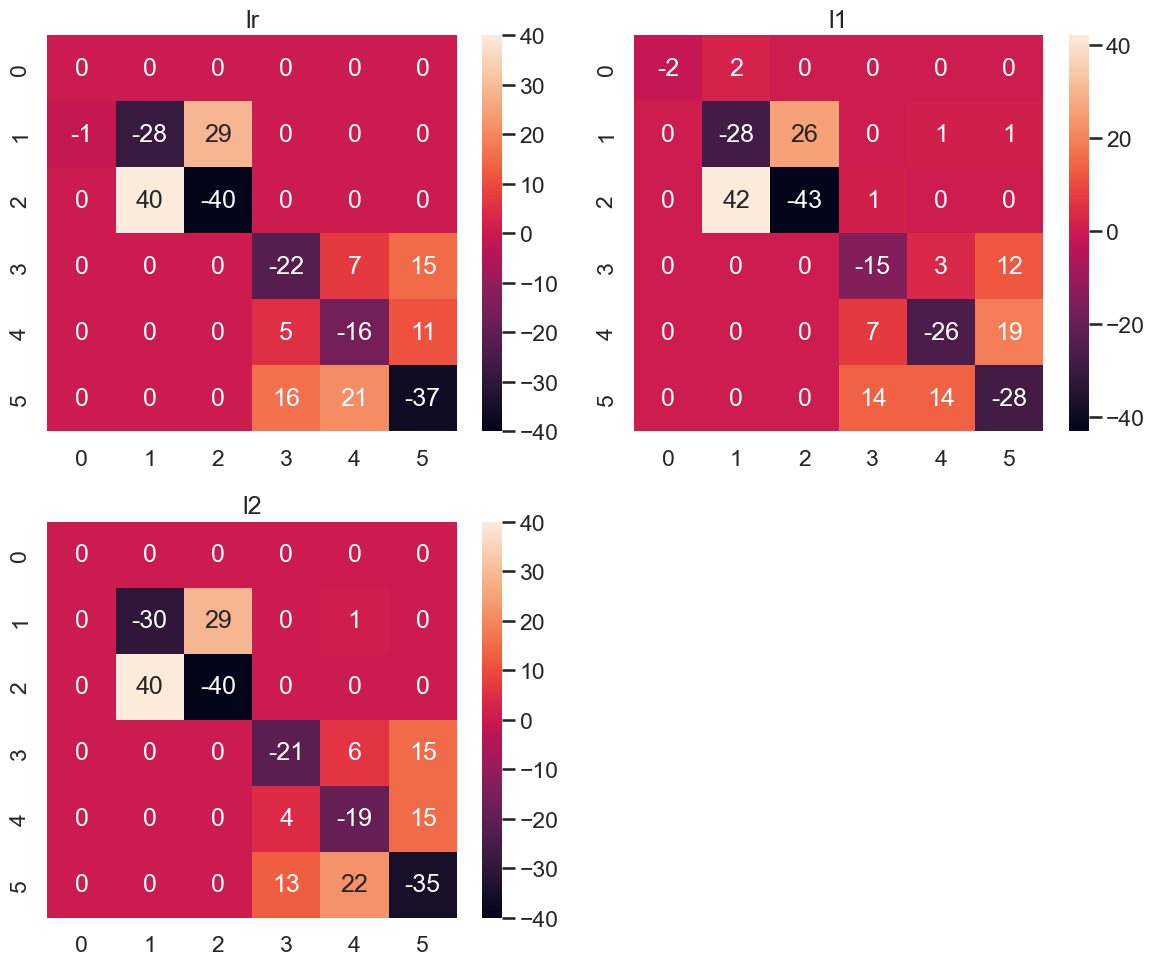

In [64]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm_new[lab]-cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);

plt.tight_layout()

# Previsão x Verdadeiro: (Modelo com redução de features) - (Modelo sem redução de features)

### A matriz de confusão indica que temos menos acertos no modelo com redução de características, visto os negativos na diagonal principal. Dependendo então da aplicação do problema.
#### Ao utilizar 561 características foi possível alcançar 98% de acurácia; enquanto ao utilizar 50 características foi alcançado cerca de 94%.
#### Em certas circunstâncias pode ser vantajoso coletar os 561 dados em troca de 98% de acurácia ao invés coletar 50 com 93% e vice versa.
#### Queremos treinar vários modelos mais rapidamente ou temos tempo para treinar um modelo demorado?